### Initial Approach

- Planned to identify high and low months/quarters by frequency across all years.

- Early analysis showed contradictions (e.g., December appeared both high and low).

**Diagnosis**

- Analysis revealed a regime shift around mid-2019 / 2020:

- Pre-2019 → noisy trends; some items declining.

- 2020–2021 → Covid-driven sharp price spikes, Q4 tends to rise.

- Concluded that mixing pre- and post-2019 data gave misleading patterns for month/quarter trends.

**Handling Pre-2019 Data**

- Initially considered dropping pre-2019 data to focus on post-regime patterns.

    - Issue: Only a few years remained post-2019, and trends were sparse/noisy → insufficient data for reliable modeling.

**Decision**

- Kept full dataset for modeling, but:

- Created a post-2019 / Covid flag to mark mid-2019 → 2021. Allows the model to learn regime-specific behavior without losing any historical context.

- Scrapped month/quarter-based exploration/feature engineering due to noise and limited years.

- Focused on item-level trends and Covid impact for features.

**Next Steps**

- Continue item-level exploration: average prices, price trends, and spike magnitudes.
- Note freatures to engineer
- Use these for model training and prediction, instead of relying on month/quarter signals.

**NOTE: post-2021 data is sparse, so predictions beyond that may be uncertain**

#### features to create during engineering:
- date features: month, quarter, year, post2018
- item_clean => cleaned names of items
- covid flag => flags mid 2019 - 2021, to potetntially show model covid happened and possibly see the price spike it caused
- item x covid_flag interaction flag => helps model see if some items may have been affected more severely (e.g., imported staples) while others were less impacted due to covid.
- item percent change from mid 2019 to 2021(or till end). to show by how much items prices spiked from covid. can leave nan from previous month with no percent change as is or just fill with 0 to signify no change
- rolling averages
- lag features => use PACF values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, f_oneway, chi2_contingency

In [2]:
df_raw= pd.read_csv("food-prices-for-nigeria-2017-2021.csv")
df_raw.head()

,ItemLabels,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,...,Jun-21,Jul-21,Aug-21,Sep-21,Oct-21,Nov-21,Lowest,Highest,Month-on-Month,Year-on-Year
0,Agric eggs medium size,512.99,520.16,507.69,518.66,522.71,514.66,498.50,485.19,487.51,...,556.47,577.55,585.64,604.99,614.89,629.82,Borno (411.67),Bayelsa (800),2.43,27.31
1,Agric eggs(medium size price of one),47.42,42.90,43.93,46.22,45.73,45.28,44.32,42.92,45.72,...,51.22,52.73,53.20,54.62,55.49,57.35,Taraba (41.51),Ogun (70.06),3.35,28.15
2,"Beans brown,sold loose",353.60,337.11,353.28,357.19,365.86,374.26,382.35,370.25,404.84,...,471.24,485.44,496.03,492.13,478.76,490.19,Bauchi (234.29),Anambra (899.4),2.39,46.47
3,Beans:white black eye. sold loose,305.53,309.85,318.45,324.04,332.28,339.64,343.96,335.71,358.13,...,431.79,444.21,457.98,461.59,464.74,476.76,Bauchi (235.22),Ebonyi (887.77),2.59,54.61
4,Beef Bone in,1001.24,995.65,1010.29,1035.45,1123.65,1129.02,1128.94,1151.38,1078.49,...,1220.33,1262.10,1274.20,1320.73,1339.77,1366.24,Taraba (975.2),Abuja (1885.99),1.98,26.37


In [3]:
df_raw.info()
#observation => data is wide shaped: more features (columns) than explanations of those features(rows)
#we see lots of columns measure the same entity => date
#fix => reshape data to long form. 

#lowest, highest, month on month, year on year are all static values, and dont capture for the entire data,and thus cant really be used accurately
#fix => drop columns and re-engineer them later to capture accurately for each month/year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ItemLabels      44 non-null     object 
 1   Jan-17          43 non-null     float64
 2   Feb-17          43 non-null     float64
 3   Mar-17          43 non-null     float64
 4   Apr-17          43 non-null     float64
 5   May-17          43 non-null     float64
 6   Jun-17          43 non-null     float64
 7   Jul-17          43 non-null     float64
 8   Aug-17          43 non-null     float64
 9   Sep-17          43 non-null     float64
 10  Oct-17          43 non-null     float64
 11  Nov-17          43 non-null     float64
 12  Dec-17          43 non-null     float64
 13  Jan-18          43 non-null     float64
 14  Feb-18          43 non-null     float64
 15  Mar-18          43 non-null     float64
 16  Apr-18          43 non-null     float64
 17  May-18          43 non-null     float

In [4]:
#create new df to hold cleaned dataset
df_clean = df_raw.copy()
# drop useless columns

df_clean = df_clean.drop(columns=["Month-on-Month","Year-on-Year","Lowest","Highest"],axis=1)

# Reshape: Melt wide to long
df_clean = df_clean.melt(
    id_vars='ItemLabels',
    var_name='Date',
    value_name='Price'
)

#view new shape
df_clean.head()

,ItemLabels,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [5]:
#rename itemlabels to item. not neccessary, just my preference
df_clean = df_clean.rename(columns={"ItemLabels":"Item"})
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [6]:
#check nulls
df_clean.isnull().sum()

Item      59
Date       0
Price    118
dtype: int64

In [7]:
#clean null columns

#drop nulls in item columns, as if there's no item, the row is useless since we're predicting prices of items
df_clean = df_clean.dropna(subset=["Item"])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 2654
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item    2596 non-null   object 
 1   Date    2596 non-null   object 
 2   Price   2537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 81.1+ KB


In [8]:
#check nulls in price
df_clean[df_clean['Price'].isnull()]
#footer text from data file makes up the nulls in price, so we drop them

df_clean = df_clean.dropna(subset=['Price'])
df_clean.info() #all rows are balanced now

<class 'pandas.core.frame.DataFrame'>
Index: 2537 entries, 0 to 2652
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item    2537 non-null   object 
 1   Date    2537 non-null   object 
 2   Price   2537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 79.3+ KB


In [9]:
# Convert date column to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format= '%b-%y')
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,2017-01-01,512.99
1,Agric eggs(medium size price of one),2017-01-01,47.42
2,"Beans brown,sold loose",2017-01-01,353.60
3,Beans:white black eye. sold loose,2017-01-01,305.53
4,Beef Bone in,2017-01-01,1001.24


In [10]:
#split date into month, year,quarter features. we dont split up to day as all days are on default(the first day of the month)
#we create this feature before the split because it doesnt look at target, and thus cant create leak. and we need it for further exploration
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Quarter'] = df_clean['Date'].dt.quarter
df_clean.head()

,Item,Date,Price,Year,Month,Quarter
0,Agric eggs medium size,2017-01-01,512.99,2017,1,1
1,Agric eggs(medium size price of one),2017-01-01,47.42,2017,1,1
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1
4,Beef Bone in,2017-01-01,1001.24,2017,1,1


In [11]:
#for this model, we are working with only some selected staple foods

#view items
print(df_clean['Item'].unique())

#select staples
staples = ['Gari white,sold loose',
           'Gari yellow,sold loose',
           'Maize grain white sold loose', 
           'Maize grain yellow sold loose',
           'Rice agric sold loose',
           'Rice local sold loose',
           'Rice Medium Grained',
           'Rice,imported high quality sold loose',
           'Vegetable oil:1 bottle,specify bottle',
           'Yam tuber',
           'Beans brown,sold loose',
           'Beans:white black eye. sold loose',
           'Bread unsliced 500g',]

#filter by staples
df_staples = df_clean[ df_clean['Item'].isin(staples) ].copy()

['Agric eggs medium size' 'Agric eggs(medium size price of one)'
 'Beans brown,sold loose' 'Beans:white black eye. sold loose'
 'Beef Bone in' 'Beef,boneless' 'Bread sliced 500g' 'Bread unsliced 500g'
 'Broken Rice (Ofada)' 'Catfish (obokun) fresh' 'Catfish :dried'
 'Catfish Smoked' 'Chicken Feet' 'Chicken Wings' 'Dried Fish Sardine'
 'Evaporated tinned milk carnation 170g'
 'Evaporated tinned milk(peak), 170g' 'Frozen chicken'
 'Gari white,sold loose' 'Gari yellow,sold loose'
 'Groundnut oil: 1 bottle, specify bottle' 'Iced Sardine' 'Irish potato'
 'Mackerel : frozen' 'Maize grain white sold loose'
 'Maize grain yellow sold loose' 'Mudfish (aro) fresh' 'Mudfish : dried'
 'Onion bulb' 'Palm oil: 1 bottle,specify bottle' 'Plantain(ripe)'
 'Plantain(unripe)' 'Rice agric sold loose' 'Rice local sold loose'
 'Rice Medium Grained' 'Rice,imported high quality sold loose'
 'Sweet potato' 'Tilapia fish (epiya) fresh' 'Titus:frozen' 'Tomato'
 'Vegetable oil:1 bottle,specify bottle'
 'Wheat flou

In [12]:
#change item names to cleaner, easier to use and understand names => 'Bread unsliced 500g' = 'Bread
item_map = {'Gari white,sold loose': 'White Garri',
            'Gari yellow,sold loose': 'Yellow Garri',
            'Maize grain white sold loose': 'White Maize',
            'Maize grain yellow sold loose': 'Yellow Maize',
            'Rice agric sold loose': 'Agric Rice',
            'Rice local sold loose': 'Local Rice', 
            'Rice Medium Grained': 'Medium Grain Rice',
            'Rice,imported high quality sold loose': 'Imported Rice',
            'Vegetable oil:1 bottle,specify bottle': 'Vegetable oil',
            'Yam tuber': 'Yam',
            'Beans brown,sold loose': 'Brown Beans', 
            'Beans:white black eye. sold loose': 'White Beans',
            'Bread unsliced 500g': 'Bread',
}
#create a new column with the cleaned item names
df_staples['Item_Clean'] = df_staples['Item'].map(item_map)
df_staples.head()

,Item,Date,Price,Year,Month,Quarter,Item_Clean
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1,Brown Beans
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1,White Beans
7,Bread unsliced 500g,2017-01-01,270.25,2017,1,1,Bread
18,"Gari white,sold loose",2017-01-01,219.56,2017,1,1,White Garri
19,"Gari yellow,sold loose",2017-01-01,255.83,2017,1,1,Yellow Garri


In [13]:
df_staples.groupby('Item_Clean')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Clean,,,,,,,,
Agric Rice,59.0,370.278814,53.919840,310.03,323.040,351.09,419.460,469.53
Bread,59.0,288.229661,23.540489,258.70,274.405,278.66,289.745,366.46
Brown Beans,59.0,367.621356,57.570427,267.81,327.030,368.98,396.035,496.03
Imported Rice,59.0,434.795593,75.034526,352.83,370.680,409.20,508.920,568.75
Local Rice,59.0,327.759492,51.212330,271.10,280.795,313.10,382.880,421.02
Medium Grain Rice,59.0,366.362034,55.761917,304.90,317.400,344.40,419.235,476.67
Vegetable oil,59.0,573.679322,89.724844,485.05,514.450,546.85,586.520,876.47
White Beans,59.0,333.726271,54.663086,241.74,296.185,332.28,356.180,476.76
White Garri,59.0,226.319322,56.027572,145.31,166.625,216.72,273.850,329.20


In [14]:
#create column with month names for easier understanding when exploring data

# Month name mapped directly from month number
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_staples.insert(df_staples.columns.get_loc('Month') + 1, 'Month_Name', df_staples['Month'].map(month_map))

# Force order directly on month names
df_staples['Month_Name'] = pd.Categorical(
    df_staples['Month_Name'],
    categories=["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"],
    ordered=True
)

df_staples.head()

,Item,Date,Price,Year,Month,Month_Name,Quarter,Item_Clean
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,Jan,1,Brown Beans
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,Jan,1,White Beans
7,Bread unsliced 500g,2017-01-01,270.25,2017,1,Jan,1,Bread
18,"Gari white,sold loose",2017-01-01,219.56,2017,1,Jan,1,White Garri
19,"Gari yellow,sold loose",2017-01-01,255.83,2017,1,Jan,1,Yellow Garri


###  Exploring Quarter against price 
- **GOAL:** see which quarters have prices that are usally high vs usually low

##### Deprecated Approach:

- Initial analysis (full dataset) showed contradictions:

    - Q4 appeared as highest quarter 3 times (post-2018)

    - Q4 appeared as lowest quarter 2 times (pre-2019)

    - Q1 most frequently occurred as the lowest quarter overall

    - This mixing of regimes caused misleading frequency counts.

- Planned flags: pre19_high_quarter, pre19_low_quarter, post18_high_quarter, post18_low_quarter.

- If a quarter was highest in that year → mark 1 in corresponding _high column.

- If lowest → mark 1 in corresponding _low column.

##### Approved Approach:

- Drop pre-2019 data (since project goal is forward prediction).

- Perform quarterly analysis only on post-2018 data.

- Generate high/low quarter flags based solely on the relevant regime.

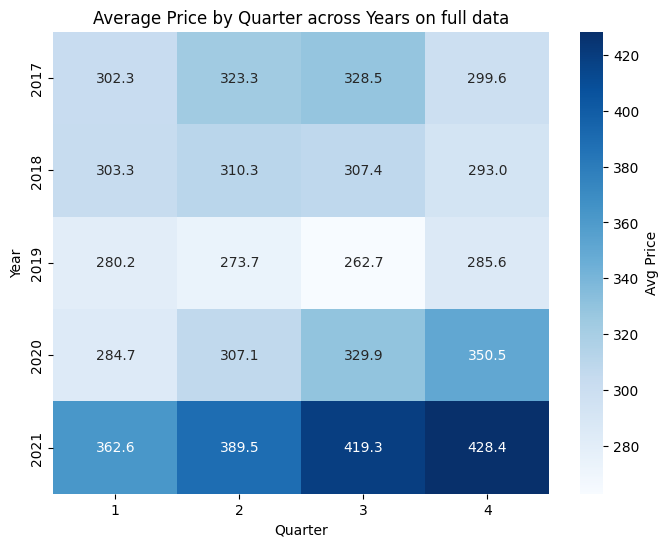

In [15]:
# #old approach:  Group by Year + Quarter
quarterly_avg = df_staples.groupby(['Year', 'Quarter'], as_index=False)['Price'].mean()

# Pivot for heatmap
pivot = quarterly_avg.pivot(index='Year', columns='Quarter', values='Price')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label':'Avg Price'})
plt.title("Average Price by Quarter across Years on full data")
plt.xlabel("Quarter")
plt.ylabel("Year")
plt.show()

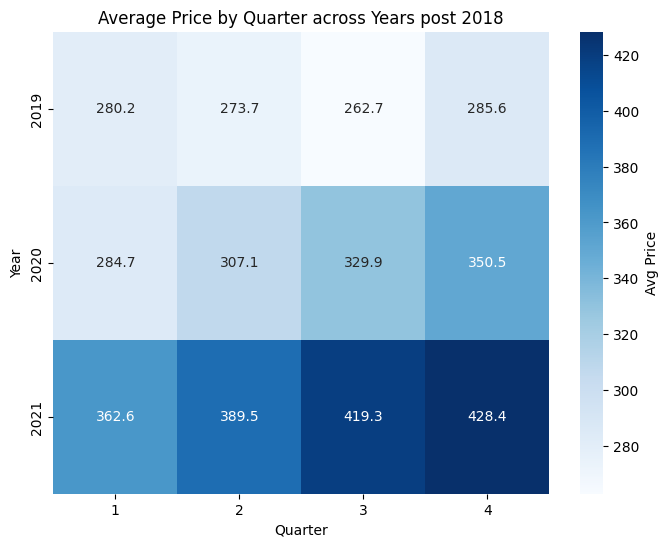

In [16]:
#create new df to hold post 2018 data
df_post18 = df_staples[ df_staples['Year'] > 2018 ].copy()

#visualize average price per quarter over years post 2018
quarterly_avg = df_post18.groupby(['Year', 'Quarter'], as_index=False)['Price'].mean()

# Pivot for heatmap
pivot = quarterly_avg.pivot(index='Year', columns='Quarter', values='Price')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label':'Avg Price'})
plt.title("Average Price by Quarter across Years post 2018")
plt.xlabel("Quarter")
plt.ylabel("Year")
plt.show()


### Quarter Exploration Findings

**Observation:**

- Pre-2019: Q4 was often the lowest quarter.

- Post-2019: Q4 flipped to the highest quarter.

- However, post-2019 dataset covers only ~3 years. Within those, one year shows no clear pattern, breaking consistency.

**Implication:**

- Seasonal patterns (high/low quarters) are unstable.

- With such limited post-2019 data, the model cannot learn reliable seasonality.

- Hand-crafted “high/low” flags risk overfitting to noise instead of capturing true structure.

**Decision:**

- Scrap deep feature extraction for quarters/months.

- Instead, use full data, keep basic date features (month, quarter, year) + a regime flag (pre2019 = 1).

- Focus on trend and lag features, which are more stable and learnable by the model.

In [17]:
# # average price per year-quarter
# df_year_quarter = df_staples.groupby(["Year", "Quarter"])["Price"].mean().reset_index()

# # get idx of max and min quarter per year
# yearly_quarter_extremes = (
#     df_year_quarter.groupby("Year")
#     .apply(lambda g: pd.Series({
#         "high_quarter": g.loc[g["Price"].idxmax(), "Quarter"],
#         "low_quarter": g.loc[g["Price"].idxmin(), "Quarter"],
#     }))
#     .reset_index()
# )

# print(yearly_quarter_extremes)


In [18]:
# high_counts = yearly_quarter_extremes["high_quarter"].value_counts().sort_index()
# low_counts  = yearly_quarter_extremes["low_quarter"].value_counts().sort_index()

# print("High quarter frequency:\n", high_counts)
# print("Low quarter frequency:\n", low_counts)




## Deprecated Approach:
### Quarter x Month exploration
**Goal:** see which months in each quarter are usually high vs low across years.

##### High month frequency

- Shows how many times each month was the highest in its quarter across all years.

- Jun and Mar flagged 3 times → month features. i.e Q1_high if month == mar else 0, q2_high if month == jun else 0

- Apr and Dec flagged only once → probably less reliable.

##### Low month frequency

- Shows how many times each month was the lowest in its quarter across all years.

- Apr flagged 4 times → strong candidate for “quarter-low” month features. i.e q2_low if month == apr else 0

- Jun flagged only once → likely not consistently low, so may skip.

In [19]:
# # Average price per year-quarter-month
# df_yqm = df_staples.groupby(["Year", "Quarter", "Month_Name"], observed=False)["Price"].mean().reset_index()

# # Threshold: only consider month as high/low if difference from quarter avg >= 1% (adjust as needed)
# threshold = 0.01  # 1% difference

# def month_extremes(group):
#     quarter_avg = group["Price"].mean()
#     high_row = group.loc[group["Price"].idxmax()]
#     low_row  = group.loc[group["Price"].idxmin()]

#     high_flag = high_row["Price"] >= quarter_avg * (1 + threshold)
#     low_flag  = low_row["Price"]  <= quarter_avg * (1 - threshold)

#     return pd.Series({
#         "high_month": high_row["Month_Name"] if high_flag else None,
#         "low_month": low_row["Month_Name"]  if low_flag else None
#     })

# monthly_extremes = df_yqm.groupby(["Year", "Quarter"]).apply(month_extremes).reset_index()

# print(monthly_extremes)


In [20]:
# #we use 5 years of data, so only months with 3 or more occurences across years can be cosidered as signals. else we just skip

# high_months = monthly_extremes["high_month"].value_counts()
# high_months = high_months[high_months >= 3].sort_index()

# low_months = monthly_extremes["low_month"].value_counts()
# low_months = low_months[low_months >= 3].sort_index()

# print("High month frequency:\n", high_months)
# print("Low month frequency:\n", low_months)


### Deprecated:
#### Quarter x Item Exploration
**Goal:** see for each item, which quarter has the highest vs lowest prices across years

##### Approach:
- Per-item Flags:
    - For each item, find the quarter(s) that are historically highest (count >= 3). Create a column for each item, e.g., rice_q4_high.
    - Value = 1 if the row corresponds to the item's high quarter, else 0.

- Frequency threshold (count >= 3) ensures only consistent high quarters are flagged.
    - After feature importance analysis, redundant flags can be dropped.
    - Only flags quarters with clear historical signal, skips ambiguous ones.

In [21]:
# # 1. Compute average price per item per year per quarter
# item_quarter_avg = df_staples.groupby(['Item_Clean','Year','Quarter'], as_index=False)['Price'].mean()

# # 2. For each item-year, find the quarter with highest and lowest price
# high_low_quarters = item_quarter_avg.groupby(['Item_Clean','Year']).apply(
#     lambda x: pd.Series({
#         'High_Quarter': x.loc[x['Price'].idxmax(),'Quarter'],
#         'Low_Quarter': x.loc[x['Price'].idxmin(),'Quarter']
#     })
# ).reset_index()

# # 3. Count frequency of each high/low quarter across years per item
# high_quarter_freq = high_low_quarters.groupby(['Item_Clean','High_Quarter']).size().reset_index(name='count')
# low_quarter_freq  = high_low_quarters.groupby(['Item_Clean','Low_Quarter']).size().reset_index(name='count')

# # 4. Optionally: filter only quarters that appear >= threshold times (e.g., 2 years)
# threshold = 2
# high_quarter_freq = high_quarter_freq[high_quarter_freq['count'] >= threshold]
# low_quarter_freq  = low_quarter_freq[low_quarter_freq['count'] >= threshold]

# # 5. Result: which quarter is usually high vs low for each item
# print("High quarter frequency per item:\n", high_quarter_freq)
# print("\nLow quarter frequency per item:\n", low_quarter_freq)


## Deprecated Approach:
### Months x Price Exploration
**Goal:** see which months over the years usually have high vs low prices. 
- since months are x3 of quarters, we aim to flag 2 or 3 high/low price months as signal 

In [22]:
# df_avg_month_over_years = df_staples.groupby(['Year','Month_Name'], observed=False)['Price'].mean().reset_index()
# df_avg_month_over_years.rename(columns={"Price": "Avg_Price_Of_Items"}, inplace=True) #changed to average price, coz the label price kept confusing, as 
# #i forgot we're calculating average price over all items for each month, butt i kept reading it as just price, so which price????
# df_avg_month_over_years


# # month_over_years_avg =  df_staples.groupby(['Month_Name'], as_index=False, observed=True)['Price'].mean()
# # print('highest month on average: \n',month_over_years_avg.loc[month_over_years_avg ['Price'].idxmax() ] )
# # print('lowest month on average:\n', month_over_years_avg.loc[month_over_years_avg['Price'].idxmin()] )


In [23]:
#visualization of months average prices to solidify ealier observation from quarter exploration

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Pivot for heatmap
pivot = df_avg_month_over_years.pivot(index="Year", columns="Month_Name", values="Avg_Price_Of_Items")
pivot = pivot[month_order]  # reorder columns

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Avg Price'})

plt.title("Average Price by Month across Years")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()



NameError: name 'df_avg_month_over_years' is not defined

In [ ]:
# def top_months_per_year(df, price_col="Avg_Price_Of_Items", month_col="Month_Name", year_col="Year", top_n=2):
#     """
#     For each year, get the top N highest and lowest months by price.
    
#     Returns two DataFrames:
#     - high_months: top N months per year (highest prices)
#     - low_months:  top N months per year (lowest prices)
#     """
#     high_months = (
#         df.groupby(year_col, group_keys=False)
#         .apply(lambda x: x.nlargest(top_n, price_col)[[year_col, month_col, price_col]])
#     )
    
#     low_months = (
#         df.groupby(year_col, group_keys=False)
#         .apply(lambda x: x.nsmallest(top_n, price_col)[[year_col, month_col, price_col]])
#     )
    
#     return high_months, low_months

# tmpy = top_months_per_year(df_avg_month_over_years)
# tmpy


In [ ]:
# def month_frequency(df, month_col="Month_Name"):
#     """
#     Count how often each month appears.
#     """
#     return df[month_col].value_counts().sort_index()

# # Get top 2 highs and lows for each year
# highs, lows = top_months_per_year(df_avg_month_over_years, top_n=2)

# print("High months frequency:")
# print(month_frequency(highs))

# print("\nLow months frequency:")
# print(month_frequency(lows))


### Items x Price Exploration
##### While quarter and month explorations were scrapped due to structural breaks post-2019 and limited years of data (making seasonal signals unreliable), item-level exploration remains valuable. Unlike seasonality, relative price levels across items are more stable over time i.e rice may generally cost more than beans, yam more than gari, etc. Exploring items helps us identify:

**Goal:** 
- see which items are generally more expensive / cheaper
- see if price change in one item influences price change in another
- see item volatility/stability
### Items x Month Exploration => Deprecated
**Goal:**
- see if any item is cheaper/expensive in certain months
### Items x Quarter Exploration => Deprecated
**Goal:**
- see if any item is cheaper/expensive in some seasons

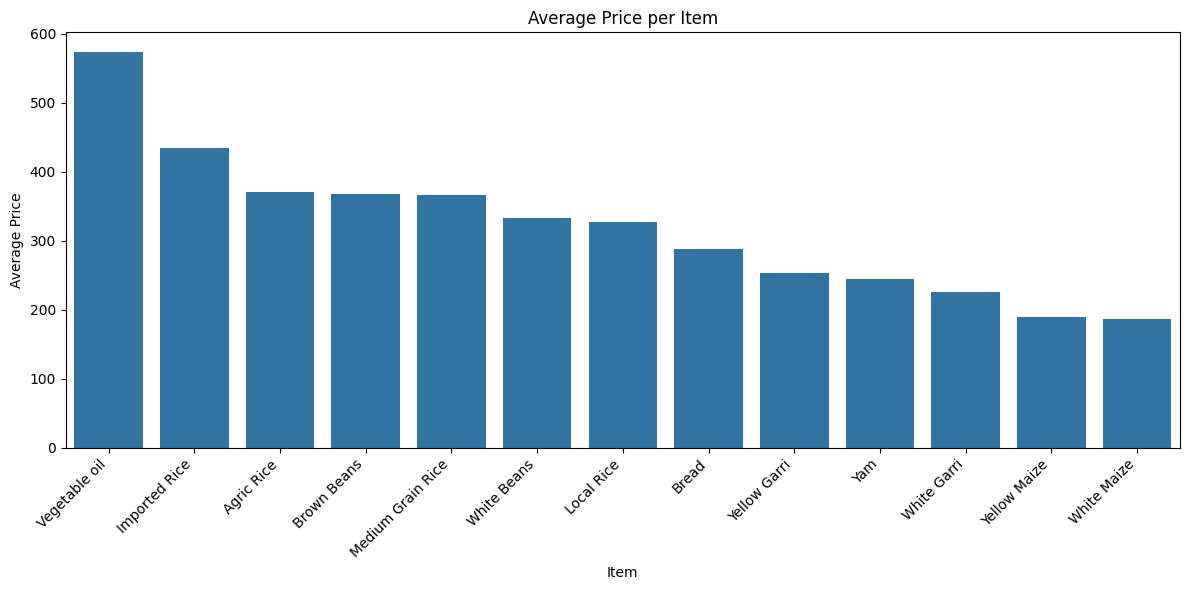

In [25]:
# Compute average price per item
avg_prices = df_staples.groupby('Item_Clean', as_index=False)['Price'].mean()

# Barplot
plt.figure(figsize=(12,6))
sns.barplot(data=avg_prices, x='Item_Clean', y='Price',
            order=avg_prices.sort_values('Price', ascending=False)['Item_Clean'])

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Titles and labels
plt.title("Average Price per Item")
plt.xlabel("Item")
plt.ylabel("Average Price")

plt.tight_layout()
plt.show()


##### Observation – Item-Level Price Differences

- From the average price plot across items:

- Consistently higher-priced items:

    - Vegetable oil sits at the top overall.
    - Among cereals/legumes, imported /Agric rice types and some bean varieties are also on the higher end.


- Consistently lower-priced items:

    - Maize, and white garri form the bottom cluster of cheaper staples, with yam being relatively low as well

Note: While not every food item can be exhaustively ranked, these categories stand out clearly as the most expensive vs cheapest across the dataset

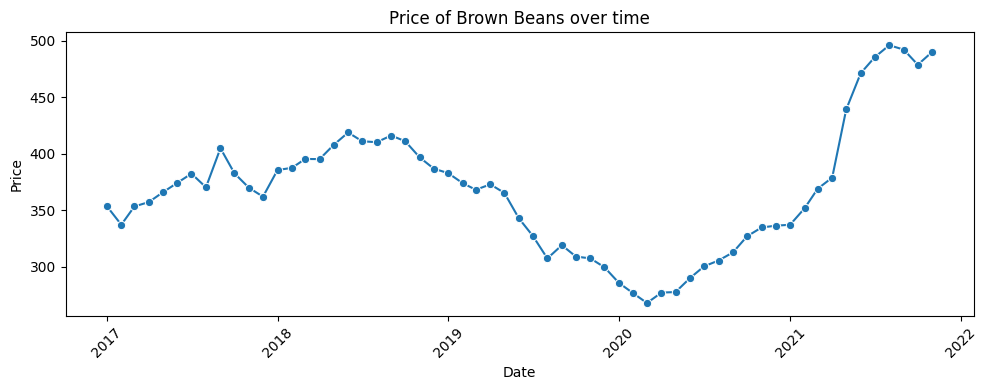

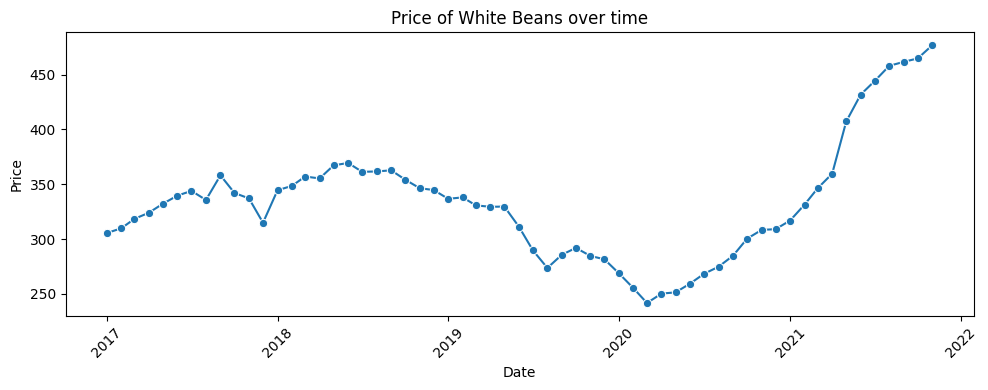

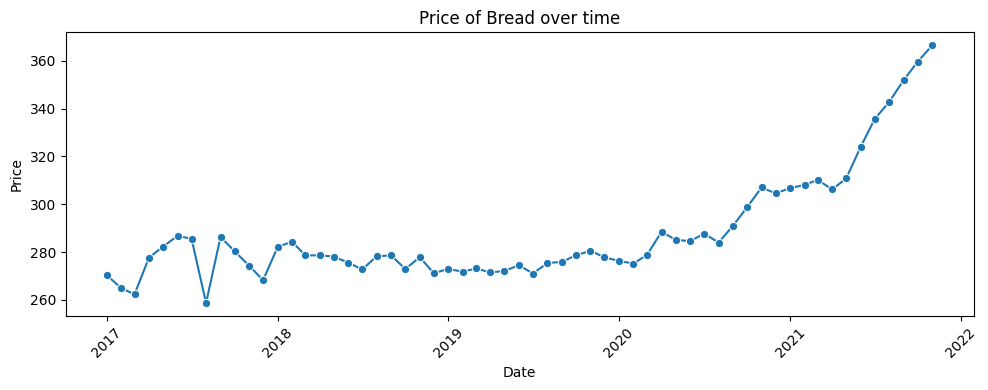

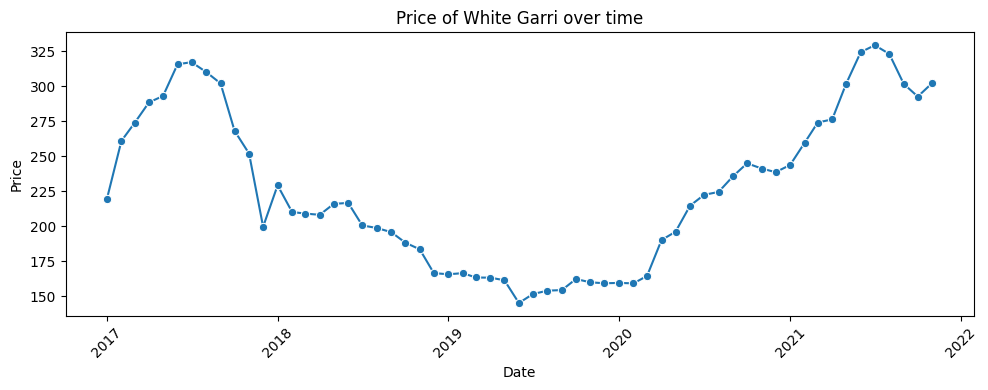

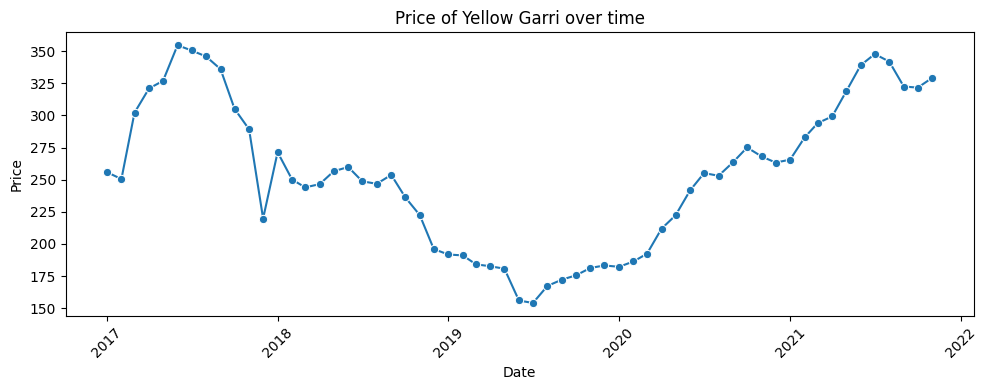

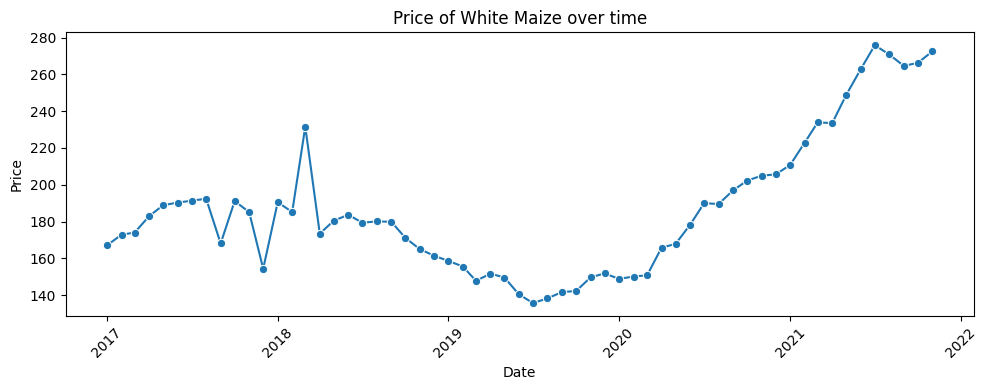

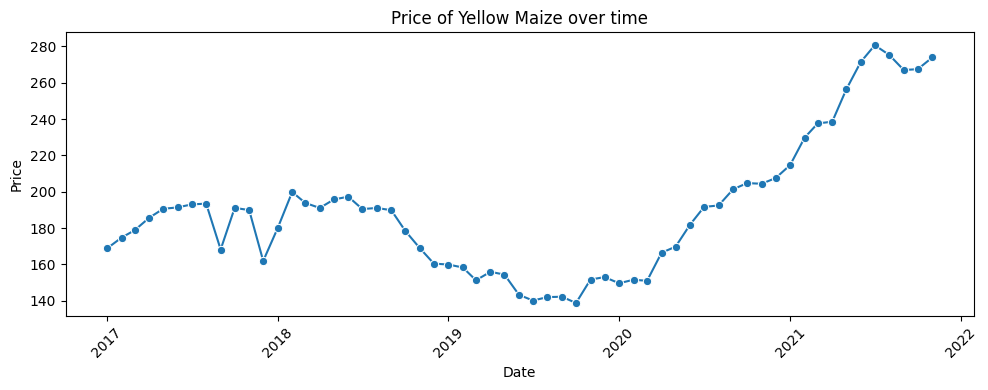

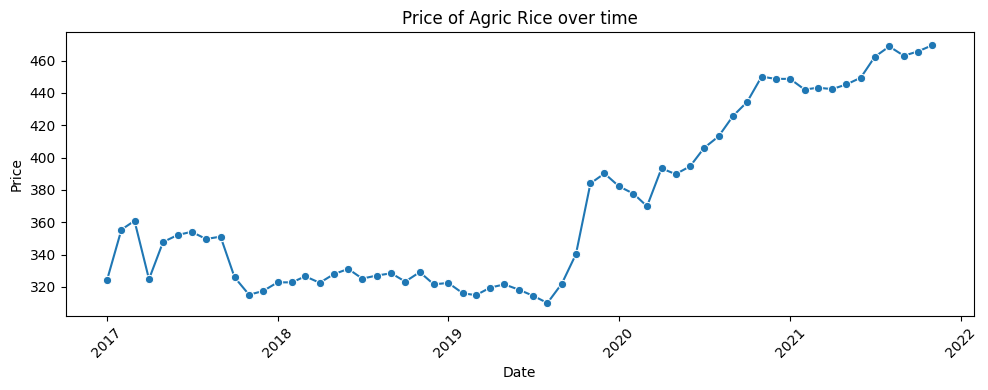

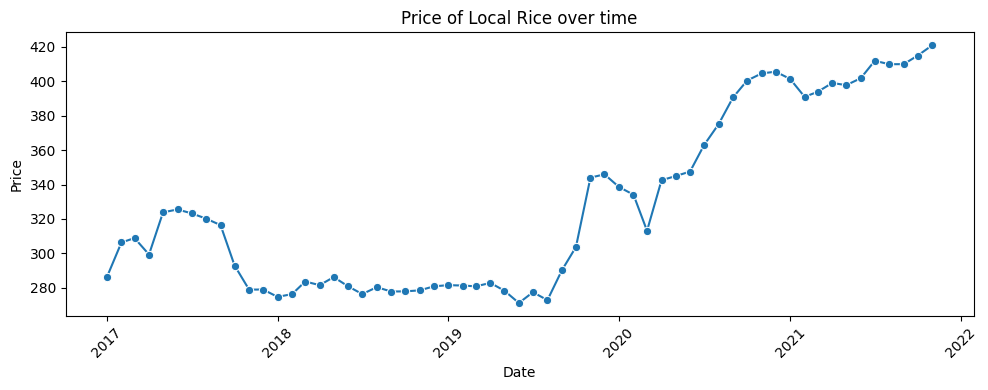

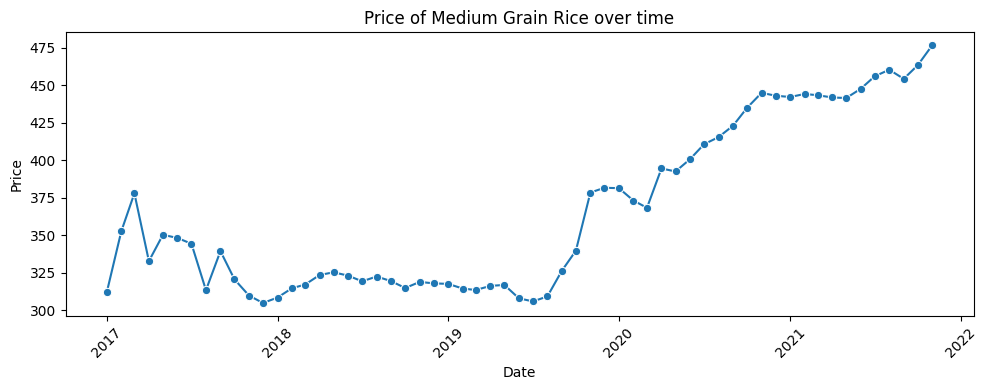

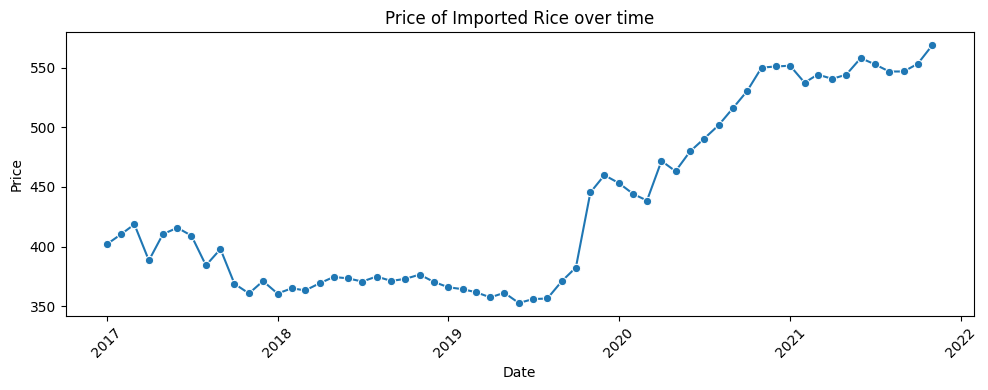

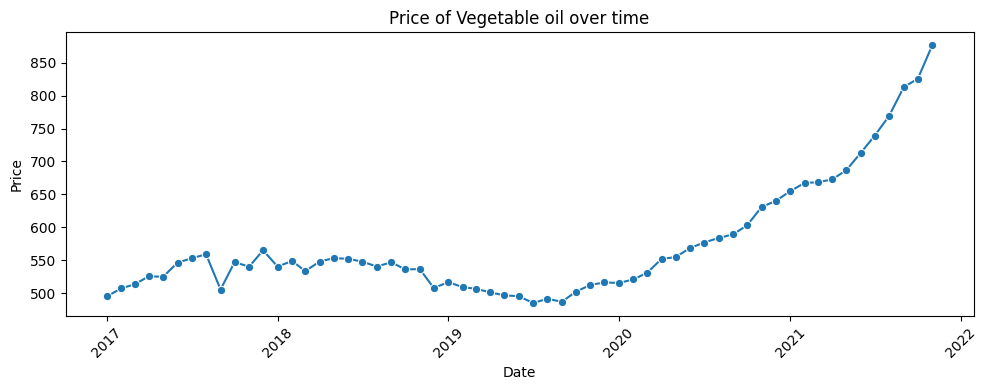

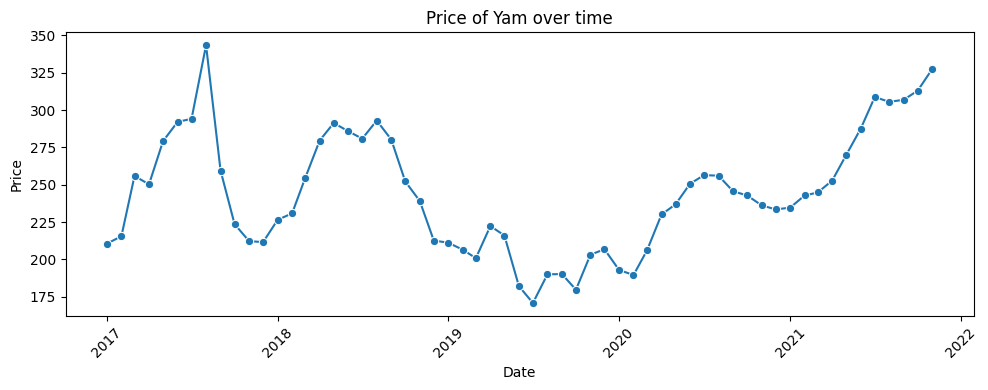

In [26]:
# Get unique items
items = df_staples['Item_Clean'].unique()

# Loop through each item and plot
for item in items:
    item_df = df_staples[df_staples['Item_Clean'] == item]
    
    plt.figure(figsize=(10,4))
    sns.lineplot(x='Date', y='Price', data=item_df, marker='o')
    
    plt.xticks(rotation=45)
    plt.title(f"Price of {item} over time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


##### Observation – COVID-19 Price Spike (2020)

Around mid 2019 - 2021, most items experienced sharp upward price spikes, likely due to COVID-19 disruptions.

Some items that were previously stable/declining rebounded sharply, reaching or surpassing their former highs, and continued to increase steadily post-2020.

In [27]:
#check items volatility

# Standard deviation per item
item_volatility = df_staples.groupby('Item_Clean')['Price'].std().reset_index()
item_volatility = item_volatility.rename(columns={'Price': 'Price_STD'})

#Coefficient of Variation (STD / Mean) for relative volatility
item_mean = df_staples.groupby('Item_Clean')['Price'].mean().reset_index()
item_mean = item_mean.rename(columns={'Price': 'Price_MEAN'})

item_volatility = item_volatility.merge(item_mean, on='Item_Clean')
item_volatility['Price_CV'] = item_volatility['Price_STD'] / item_volatility['Price_MEAN']

item_volatility.sort_values('Price_CV', ascending=False)


,Item_Clean,Price_STD,Price_MEAN,Price_CV
8,White Garri,56.027572,226.319322,0.247560
11,Yellow Garri,57.989180,253.992203,0.228311
9,White Maize,37.646570,186.738136,0.201601
12,Yellow Maize,37.888265,189.820847,0.199600
3,Imported Rice,75.034526,434.795593,0.172574
10,Yam,40.395294,244.511186,0.165208
7,White Beans,54.663086,333.726271,0.163796
2,Brown Beans,57.570427,367.621356,0.156603
6,Vegetable oil,89.724844,573.679322,0.156402
4,Local Rice,51.212330,327.759492,0.156250


**Observation:** Coefficient of variation across items is low (max 0.24), indicating that all staple prices are relatively stable in their movement.

In [ ]:
#check items correlation
# Make a copy to be safe

df_corr = df_staples.copy()

pivot_df = df_corr.pivot_table(index='Date', columns='Item_Clean', values='Price')

# Compute correlations
corr_matrix = pivot_df.corr()

# Convert to long format for easier inspection
corr_long = (
    corr_matrix
    .reset_index()        # keep Item names in a column
    .melt(id_vars='Item_Clean', var_name='Item_2', value_name='Correlation')
    .rename(columns={'Item_Clean': 'Item_1'})
)

# Remove self-correlations
corr_long = corr_long[corr_long['Item_1'] != corr_long['Item_2']]

# Sort by absolute correlation
corr_long = corr_long.reindex(corr_long['Correlation'].abs().sort_values(ascending=False).index)

# Show top 10
corr_long.head(20)



In [ ]:
# Remove duplicate and self-pairs
corr_unique = corr_long[corr_long['Item_1'] < corr_long['Item_2']]

# Categorize correlations
def corr_category(x):
    if x > 0.8:
        return 'High'
    elif x > 0.5:
        return 'Medium'
    else:
        return 'Low'

corr_unique['Category'] = corr_unique['Correlation'].apply(corr_category)

# Summary counts
corr_unique['Category'].value_counts()


In [ ]:
# Pivot to have items as columns
pivot_df = df_corr.pivot_table(index='Date', columns='Item_Clean', values='Price')

# Compute correlation matrix
corr = pivot_df.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Item Prices")
plt.show()


In [ ]:
# #plot for items x month

# # Loop through each item
# for item in df_staples['Item_Clean'].unique():
#     item_df = df_staples[df_staples['Item_Clean'] == item]
    
#     # Compute average price per month
#     monthly_avg = item_df.groupby('Month_Name', as_index=False, observed=False)['Price'].mean()
    
#     plt.figure(figsize=(8,4))
#     sns.lineplot(data=monthly_avg, x='Month_Name', y='Price', marker='o')
    
#     plt.title(f"{item} Price Across Months")
#     plt.xlabel("Month")
#     plt.ylabel("Average Price")
#     plt.tight_layout()
#     plt.show()



In [ ]:
# #plot for items x quarter

# # Get unique items
# items = df_staples['Item_Clean'].unique()

# # Quarter color palette (4 distinct colors)
# quarter_colors = {
#     1: "tab:blue", 
#     2: "tab:green", 
#     3: "tab:orange", 
#     4: "tab:red"
# }

# for item in items:
#     item_df = df_staples[df_staples['Item_Clean'] == item]
    
#     plt.figure(figsize=(10,4))
    
#     # Plot the line (grey trend)
#     sns.lineplot(
#         x="Date", y="Price", data=item_df,
#         color="lightgrey", linewidth=1.5
#     )
    
#     # Scatter points, colored by quarter
#     for q, group in item_df.groupby("Quarter"):
#         plt.scatter(group["Date"], group["Price"], 
#                     color=quarter_colors[q], label=f"Q{q}")
    
#     plt.xticks(rotation=45)
#     plt.title(f"Price of {item} over time (dots colored by quarter)")
#     plt.xlabel("Date")
#     plt.ylabel("Price")
#     plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc="upper left")
#     plt.tight_layout()
#     plt.show()


Yellow maize shows uniformly high correlations (≥0.71) with all items, making it a potential proxy for overall food market movements.
therefore a spike or drop in the price of yellow maize could signal price spike/drops in other stape foods.

In [24]:
# Filter to Yellow Maize
maize = df_staples[df_staples["Item_Clean"] == "Yellow Maize"].sort_values("Date")
y = maize["Price"].values

# Compute autocorrelation for lags up to 24 months
max_lag = 24
acf_vals = [pd.Series(y).autocorr(lag=i) for i in range(1, max_lag+1)]

acf_df = pd.DataFrame({
    "Lag": range(1, max_lag+1),
    "ACF": acf_vals
})

print(acf_df)


    Lag       ACF
0     1  0.968612
1     2  0.934024
2     3  0.911346
3     4  0.861544
4     5  0.801269
5     6  0.740088
6     7  0.668423
7     8  0.576886
8     9  0.463285
9    10  0.346707
10   11  0.220093
11   12  0.078824
12   13 -0.066146
13   14 -0.215393
14   15 -0.371963
15   16 -0.527610
16   17 -0.661758
17   18 -0.748411
18   19 -0.815080
19   20 -0.863706
20   21 -0.860153
21   22 -0.854828
22   23 -0.855321
23   24 -0.837342


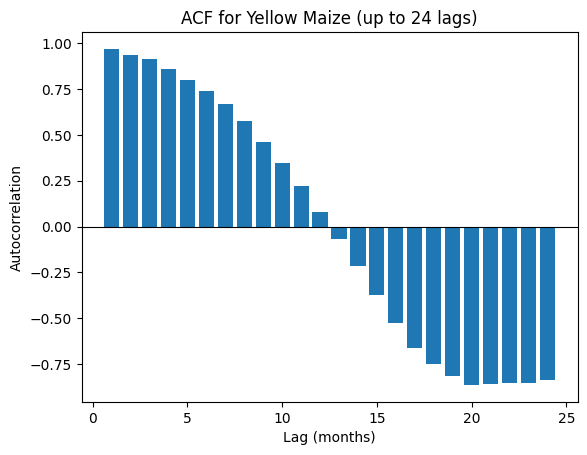

In [28]:
plt.bar(acf_df["Lag"], acf_df["ACF"])
plt.axhline(0, color="black", linewidth=0.8)
plt.title("ACF for Yellow Maize (up to 24 lags)")
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.show()


In [30]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 443.7 kB/s eta 0:00:21
   -- ------------------------------------- 0.5/9.6 MB 443.7 kB/s eta 0:00:21
   --- ------------------------------------ 0.8/9.6 MB 561.2 kB/s eta 0:00:16
   ---- ----------------------------------- 1.0/9.6 MB 640.1 kB/s eta 0:00:14
   ----- ---------------------------------- 1.3/9.6 MB 684.8 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/9.6 MB 684.8 kB/s eta 0:00:13
   ------ --------------------------------- 1.6/9.6 MB 724.5 kB/s eta 0:00:12
   ------- -----------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


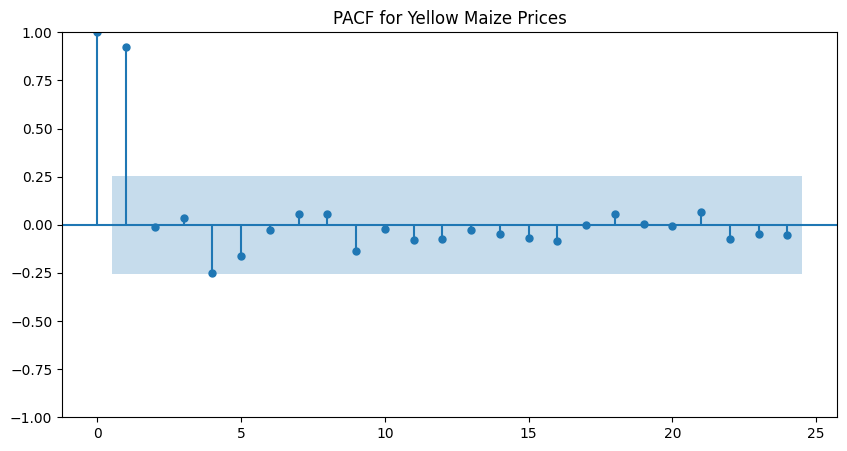

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf

# Extract just the price series
series = maize['Price'].reset_index(drop=True)

# Plot PACF up to, say, 24 lags
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(series, lags=24, ax=ax, method='ywm')
plt.title("PACF for Yellow Maize Prices")
plt.show()


In [38]:
def get_significant_pacf_lags(df, item_col='Item', price_col='Price', max_lag=24, alpha=0.05, min_val=0.2):
    """
    Compute PACF for each item and return only meaningful lags.

    Parameters:
        df : pd.DataFrame
            Dataset with columns [item_col, price_col, Date].
        item_col : str
            Column name for items.
        price_col : str
            Column name for price values.
        max_lag : int
            Maximum lag to check.
        alpha : float
            Confidence level (default 0.05 for 95% CI).
        min_val : float
            Minimum absolute PACF to consider meaningful.

    Returns:
        dict : {item_name: [list of significant lags]}
    """
    from statsmodels.tsa.stattools import pacf
    from scipy.stats import norm


    significant_lags = {}
    N_total = df[price_col].count()
    z = norm.ppf(1 - alpha/2)
    ci = z / np.sqrt(N_total)  # approximate CI

    for item in df[item_col].unique():
        series = df[df[item_col] == item].sort_values('Date')[price_col].reset_index(drop=True)
        pacf_vals = pacf(series, nlags=max_lag, method='ywm')

        # **Key change:** only keep lags where PACF is BOTH outside CI AND above min_val
        sig_lags = [lag for lag, val in enumerate(pacf_vals[1:], start=1) 
                    if abs(val) > max(ci, min_val)]
        
        significant_lags[item] = sig_lags

    return significant_lags


sig_lags_dict = get_significant_pacf_lags(df_staples, item_col='Item_Clean', price_col='Price', max_lag=24)
for item, lags in sig_lags_dict.items():
    print(f"{item}: significant PACF lags → {lags}")


Brown Beans: significant PACF lags → [1, 3]
White Beans: significant PACF lags → [1]
Bread: significant PACF lags → [1]
White Garri: significant PACF lags → [1, 3]
Yellow Garri: significant PACF lags → [1, 3, 4, 7, 11]
White Maize: significant PACF lags → [1, 2]
Yellow Maize: significant PACF lags → [1, 4]
Agric Rice: significant PACF lags → [1]
Local Rice: significant PACF lags → [1]
Medium Grain Rice: significant PACF lags → [1]
Imported Rice: significant PACF lags → [1]
Vegetable oil: significant PACF lags → [1]
Yam: significant PACF lags → [1, 7]


In [ ]:
df_staples